In [1]:
import pandas as pd
import numpy as np
import itertools
from matplotlib import pyplot as plt
import os
from math import sqrt
from tqdm import tqdm

# average
# ['1,1,1', '4,1,1', '4,1,3', '4,1,4', '13,1,6', '13,1,9', '13,1,7', '1,1,3']
# [132.98154882976834, 24758906.261347808, 16582517.988148645, 3301181.402374492, 6208886.564456862, 2171.129381420765, 134.63362559560593, 6276886.610543468]
avr = np.array([132.98154882976834, 24758906.261347808, 16582517.988148645, 3301181.402374492, 6208886.564456862, 2171.129381420765, 134.63362559560593, 6276886.610543468])



In [2]:
data = pd.read_csv('.//1_pred.csv')  # 就是附件1
data = data.sort_index()  # 整理索引 防止索引乱序
data_n = pd.DataFrame(data,columns =["user_id","metrics","ds","value_avg"])
user_id_list = list(set(data['user_id'].tolist()))
metrics_list=["1,1,1","4,1,1","4,1,3","4,1,4","13,1,6","13,1,9","13,1,7","1,1,3"]

load information

In [3]:
all_info = {}
maxlen = 122
metricNum = {}
date = {}
user_avr = {} #用户不同metrics的均值
for user_id in tqdm(user_id_list):
    m = []
    num = 0
    day = []
    u_avr = []
    for metric in metrics_list:
        d1 = np.array(data_n.loc[(data['user_id'] == user_id) & (
            data_n['metrics'] == metric), 'value_avg']).tolist()
        day.append(len(d1) if len(d1)>1 else 1)
        u_avr.append(np.mean(d1) if len(d1)>=1 else 1)
        if len(d1)<2:
            m.append(np.zeros(maxlen))
            continue
        dn = d1[-1]
        d1.extend([dn for i in range(maxlen - len(d1))])
        m.append(d1)
        num += 1
    all_info[user_id] = np.array(m)
    metricNum[user_id] = num
    date[user_id] = day
    user_avr[user_id] = u_avr

100%|██████████| 250/250 [02:18<00:00,  1.81it/s]


In [5]:
for user_id in tqdm(user_id_list):
    m = all_info[user_id]
    m = m/np.atleast_2d(avr).T
    all_info[user_id] = m

100%|██████████| 250/250 [00:00<00:00, 94355.80it/s]


calculate the rapid drop

In [9]:
i = 0
disparity = []
for user_id in tqdm(user_id_list):
    i+=1
    m = all_info[user_id]
    m = np.array(m)
    dif = np.diff(m)
    dif = dif/np.atleast_2d(user_avr[user_id]).T
    mask = dif<0 #find the index where metric drops
    mavr = np.sum(mask*dif,1)/np.sum(mask,1) #average of drop
    mavr = np.atleast_2d(mavr)
    dis = np.sum(dif*(dif<=mavr.T))/metricNum[user_id]
    disparity.append(dis)
disparity [78] =0
disparity [186] =0
disparity [204]= 0
# disparity = (disparity - np.mean(disparity)) / np.std(disparity)


  0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_11361/2344645246.py:10: RuntimeWarning: invalid value encountered in divide
  mavr = np.sum(mask*dif,1)/np.sum(mask,1) #average of drop
/tmp/ipykernel_11361/2344645246.py:8: RuntimeWarning: invalid value encountered in divide
  dif = dif/np.atleast_2d(user_avr[user_id]).T
100%|██████████| 250/250 [00:00<00:00, 13338.96it/s]


calculate the drop

In [10]:
drop = []
for user_id in tqdm(user_id_list):
    m = all_info[user_id]
    tempd = (m[...,-1]-m[...,0])/date[user_id]*220
    tempd = tempd/np.atleast_2d(user_avr[user_id]).T
    tempd = np.sum(tempd)/metricNum[user_id]
    drop.append(tempd)
drop[78] =0
drop[186] =0
drop[204]= 0
drop = np.array(drop)
drop[drop<-0.5] = -0.5+0.1*drop[drop<-0.5] 
drop[drop>0.5] = 0.5+0.1*drop[drop<-0.5] 
print(np.mean(drop))
print(np.std(drop))
drop = (drop -np.mean(drop)) /np.std(drop)


    

  0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_11361/300207103.py:5: RuntimeWarning: divide by zero encountered in divide
  tempd = tempd/np.atleast_2d(user_avr[user_id]).T
/tmp/ipykernel_11361/300207103.py:5: RuntimeWarning: invalid value encountered in divide
  tempd = tempd/np.atleast_2d(user_avr[user_id]).T
100%|██████████| 250/250 [00:00<00:00, 42890.05it/s]

-6.059939967634196e-05
0.00027062826932815556


calculate the mean flow

In [11]:
usermean = []
usersum = []
for user_id in tqdm(user_id_list):
    usersum.append(np.sum(user_avr[user_id]))
    usermean.append(np.sum(user_avr[user_id])/metricNum[user_id])
usermean[78] =0
usermean[168] =0
usermean[204]= 0
usermean = np.array(usermean)
usermean[usermean>1e7] = 1e7+0.05*usermean[usermean>1e7]
usermean = (usermean - np.mean(usermean)) / np.std(usermean)


100%|██████████| 250/250 [00:00<00:00, 42860.25it/s]


In [13]:
all_chara = np.vstack([usermean,0.7*np.array(drop)+0.3*np.array(disparity)])
all_chara = all_chara.T
print(all_chara.shape)

(250, 2)


cluster

here1
here2
[] []


/home/tracy/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:1084: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


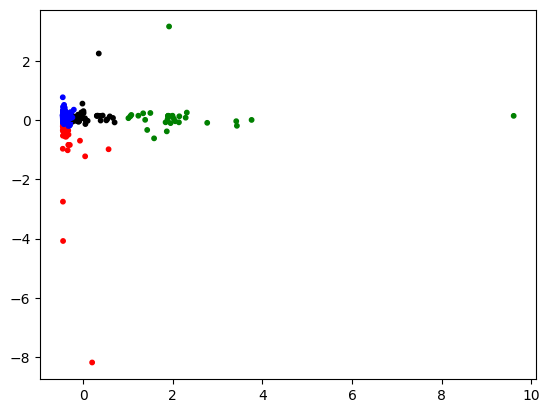

In [15]:
from pyclust import KMedoids
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
 
'''构造示例数据集（加入少量脏数据）'''
# data_TSNE = TSNE(learning_rate=100).fit_transform(all_chara)

'''准备可视化需要的降维数据'''

user = np.arange(250)
'''对不同的k进行试探性K-medoids聚类并可视化'''
ax=plt.figure()
k = KMedoids(n_clusters=4,distance='euclidean',max_iter=1000).fit_predict(all_chara)
colors = ([['red','blue','black','green'][i] for i in k])
scatter = plt.scatter(usermean,0.7*np.array(drop)+0.3*np.array(disparity),c=colors,s=10,label=colors)
# plt.title('K-medoids Resul of '.format(str(i)))
print(*scatter.legend_elements())
# plt.legend(("SH","ad","ad"),title="classes")
plt.show()